In [3]:
%matplotlib qt

In [4]:
#import stuffs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage, signal
import os, fnmatch, glob, re, time
from scipy.io import loadmat, savemat
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import colors
from matplotlib.widgets import RectangleSelector
import cv2
from PIL import Image


# Image Slices Viewer


Scroll through 2D image slices of a 3D array. https://matplotlib.org/2.1.2/gallery/animation/image_slices_viewer.html



In [48]:
from __future__ import print_function


class IndexTracker(object):
    def __init__(self, ax, X, wv, info = pd.DataFrame({"exposure" : [" "], "power" : [" "], "chipname" : [" "]}),\
                 wv_min = 0, wv_max = 1, wv_step = 1, cmin = 0, cmax = 10000):
        self.ax = ax
        self.wv_min = wv_min
        self.wv_max = wv_max
        self.wv_step = wv_step
        self.wv = wv
        
        ax.set_title('{chipname} at {power}% laser power, {exposure} ms exposure time'.format(chipname = info["chipname"].item(),\
                    power = info["power"].item(), exposure = info["exposure"].item()))
        
       
        
        self.X = X
        self.slices, rows, cols = X.shape
        #start with first slice
        self.ind = 0

        self.im = ax.imshow(self.X[self.ind, :,:], cmap = 'gray')
        plt.colorbar(self.im, label = "[a.u.]")#, ax = self.ax)
        self.im.set_clim(vmin = cmin, vmax = cmax)    
        self.update()
        
        
        
        self.rect = RectangleSelector(self.ax, self.line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)

        plt.connect('key_press_event', self.rect)
        
        #Create place holder for spectrum and second figure
        self.fig2, self.ax2 = plt.subplots(1,1)
        self.ax2.im = self.ax2.imshow(self.X[self.ind, :, 0:301 ], cmap = 'gray')
        plt.colorbar(self.ax2.im, label = "[a.u.]")
        self.ax2.im.set_clim(vmin = cmin, vmax = cmax)    
        self.update()

        

    def onscroll(self, event):
        #print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind, :, :])
        ax.set_ylabel('Wavelength {wv:.2f} nm'.format(wv = self.wv[self.ind]))
        self.im.axes.figure.canvas.draw()
        



        
    def line_select_callback(self, eclick, erelease):
        #'eclick and erelease are the press and release events'
        #x and y are interchanged, because the first dimension is the rows, therefore in representation it becomes the y
        self.y1, self.x1 = eclick.xdata, eclick.ydata
        print(self.x1)
        self.ax2.im.set_data(self.X[self.ind,:,int(self.y1)-150:int(self.y1)+150])
        self.ax2.im.axes.figure.canvas.draw()
        
      #print(" The button you used were: %s %s" % (eclick.button, erelease.button))
        
        
        
    #def line_select_callback(self, eclick, erelease):
    #    #'eclick and erelease are the press and release events'
    #    #x and y are interchanged, because the first dimension is the rows, therefore in representation it becomes the y
    #    self.y1, self.x1 = eclick.xdata, eclick.ydata
    #    self.y2, self.x2 = erelease.xdata, erelease.ydata
        
    #    print("Click Coordinate (%3.2f, %3.2f) --> Release Coordinate(%3.2f, %3.2f)" % (eclick.xdata, eclick.ydata, erelease.xdata, erelease.ydata))
    #    print("The average intensity is %3.2f" % (np.nanmean(self.X[self.ind, \
    #                                                            int(self.x1):int(self.x2),
    #                                                            int(self.y1):int(self.y2)])))
    #    self.spectrum = np.array([np.nanmean(self.X[i, int(self.x1):int(self.x2), int(self.y1):int(self.y2)]) for i in range(self.X.shape[0])])
    #    self.idx = np.where(self.spectrum==self.spectrum.max())[0]
    #    self.ax2.plot(range(self.wv_min, self.wv_max +1), self.spectrum, label = "Peak at %.2f nm \n [%.0f:%.0f, %.0f:%.0f]" % (self.wv[self.idx[0]].item(0),self.x1, self.x2, self.y1, self.y2))
    #    self.ax2.legend()
    #    self.fig2.canvas.draw()
    #    #print(" The button you used were: %s %s" % (eclick.button, erelease.button))

        
        

# Load Data

In [27]:
#Load Before Datacube
folder_name = "4"
start_wavelength = 651
end_wavelength = 660

spectra = loadmat("./CS766ProjectDataset/{folder}/Before/{start_wv}.mat".format(start_wv = start_wavelength, folder = folder_name))
spectra = np.array(spectra['spectra'])
data_cube = [spectra]
for i in range(start_wavelength + 1,end_wavelength +1):
    #placeholder
    a = loadmat("./CS766ProjectDataset/{folder}/Before/{start_wv}.mat".format(start_wv = i, folder = folder_name))
    data_cube.append(np.array(a['spectra']))
#convert to np array
before = np.array(data_cube)

#load After Datacube

spectra = loadmat("./CS766ProjectDataset/{folder}/After/{start_wv}.mat".format(start_wv = start_wavelength, folder = folder_name))
spectra = np.array(spectra['spectra'])
data_cube = [spectra]
for i in range(start_wavelength + 1,end_wavelength +1):
    #placeholder
    a = loadmat("./CS766ProjectDataset/{folder}/After/{start_wv}.mat".format(start_wv = i, folder = folder_name))
    data_cube.append(np.array(a['spectra']))
#convert to np array
after = np.array(data_cube)

# Visualize Data

In [49]:
#Hypercube in the form of an np.array
data = after
#Dimensions of the np.array hypercube
data_shape = before.shape
#wv is an array of wavelengths, incremented 1 at a time
wv = [i for i in range(start_wavelength,end_wavelength+1)]
#??
fig, ax = plt.subplots(1, 1)

#IndexTracker does what?
tracker = IndexTracker(ax, np.resize(data[np.isfinite(data)], data_shape), wv,  \
wv_min = start_wavelength, wv_max = end_wavelength, wv_step = 1,\
cmin = 0, cmax = 10)#3 * np.mean(data[np.isfinite(data)]))


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

976.9545454545453
372.9718614718611
672.1926406926405
367.43073593073564
993.5779220779218


Traceback (most recent call last):
  File "C:\Users\wadi2\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
TypeError: 'RectangleSelector' object is not callable
Traceback (most recent call last):
  File "C:\Users\wadi2\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
TypeError: 'RectangleSelector' object is not callable
Traceback (most recent call last):
  File "C:\Users\wadi2\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
TypeError: 'RectangleSelector' object is not callable


688.816017316017
694.3571428571424
389.5952380952376
395.1363636363633
361.8896103896102
378.51298701298697
411.7597402597403
384.0541125541124
389.5952380952376
389.5952380952376
389.5952380952376


In [6]:
img = before[4]
print(img.shape)

(2048, 2048)


In [2]:
#Setting JupyterNotebook to full screen

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

9406.0
0.0
[[ 8.296029   9.21164    8.939925  ...  8.749315   8.98557    7.229487 ]
 [ 8.520497   8.514612   9.440977  ...  8.707953   7.7846346  7.9321074]
 [ 8.77407    8.691293   8.3312025 ...  9.32249    8.905263   8.143275 ]
 ...
 [ 8.835308   9.404066   9.653491  ... 10.996695  10.56748   10.806853 ]
 [ 9.601769   9.145454   8.583043  ... 10.454268  11.334975  11.97931  ]
 [12.146418   9.750314   9.744417  ... 10.981651  11.66279   11.731872 ]]
[ 213  427 2174 ...    0    0    1]
[0.000000e+00 1.881200e+00 3.762400e+00 ... 9.402237e+03 9.404119e+03
 9.406000e+03]


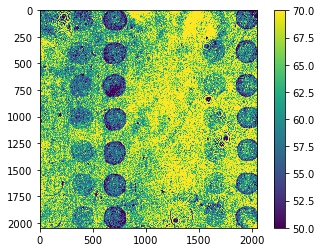

In [4]:
#Mike getting a basic image to show up
import cv2 as cv
img = before[2]
data_shape = img.shape
#img = np.resize(img[np.isfinite(img)], data_shape)
### Where is the data?
print(np.amax(img ))
print(np.amin(img))
print(img)
hist, bin_edges=np.histogram(img, bins=5000, range=None, normed=None, weights=None, density=None)
print(hist)
print(bin_edges)
##### End of where is the data stuff
fig, ax = plt.subplots()
#Normalize the data for viewing with an 8bit viewer like imshow
dst	= cv.normalize(img, None, 0, 65500, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#colormap for contrast
#color = cv2.applyColorMap(dst, cv2.COLORMAP_JET)

im = ax.imshow(dst, interpolation='nearest',
               vmin=50, vmax=70)
fig.colorbar(im)
plt.show()


#Displaying the normalized data
cv2.imshow('before',dst)


    

For Andrew - assuming imports are run at the top of the document, the following cell should generate about 5 Hough circles. I have exported them as a list, though feel free to adjust that if something else would work better for you.

In [73]:
## Playing with Hough circles
##Maybe iterate through different param1 values and see which gives best results by some metric
import cv2 as cv
###########################Load data######################
#Load Before Datacube
folder_name = "5"
start_wavelength = 651
end_wavelength = 660

spectra = loadmat("./CS766ProjectDataset/{folder}/Before/{start_wv}.mat".format(start_wv = start_wavelength, folder = folder_name))
spectra = np.array(spectra['spectra'])
data_cube = [spectra]
for i in range(start_wavelength + 1,end_wavelength +1):
    #placeholder
    a = loadmat("./CS766ProjectDataset/{folder}/Before/{start_wv}.mat".format(start_wv = i, folder = folder_name))
    data_cube.append(np.array(a['spectra']))
#convert to np array
before = np.array(data_cube)

#load After Datacube

spectra = loadmat("./CS766ProjectDataset/{folder}/After/{start_wv}.mat".format(start_wv = start_wavelength, folder = folder_name))
spectra = np.array(spectra['spectra'])
data_cube = [spectra]
for i in range(start_wavelength + 1,end_wavelength +1):
    #placeholder
    a = loadmat("./CS766ProjectDataset/{folder}/After/{start_wv}.mat".format(start_wv = i, folder = folder_name))
    data_cube.append(np.array(a['spectra']))
#convert to np array
after = np.array(data_cube)
############################Done Loading Data#######################

wavelength = 2 #Technically 650+wavelength, but this gets the correct position in the image stack
beforeSingleWavelength = before[wavelength]
afterSingleWavelength = after[wavelength]
#img = (img16/256).astype('uint8')
#img = cv.GaussianBlur( img, (9, 9), 0 );

#cv.imshow('detected circles',cimg)
dst	= cv.normalize(beforeSingleWavelength, None, 0, 65500, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cimg = cv.cvtColor(dst,cv.COLOR_GRAY2BGR)
dst = cv.medianBlur(dst, 3)
dts = cv.GaussianBlur( dst, (9, 9), 2 )
#cv2.imshow('before',dst)
#Hough circle transform https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
# One of the most important features is param1. Min and max raidus will need to be determined based on batch varaition

circles = cv.HoughCircles(dts,cv.HOUGH_GRADIENT,1,250,param1=18,param2=15,minRadius=90,maxRadius=110)
print("shape of the before image circle results")
#print(circles)
print(circles.shape)
#show blurred image
if circles is not None:
    circles = np.uint16(np.around(circles))

    for i in circles[0,:]:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    #Show before image with circles drown on
    cv.imshow('detected circles before',cimg)

#cv.imshow('detected circles',cimg)
dsta	= cv.normalize(afterSingleWavelength, None, 0, 65500, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cimga = cv.cvtColor(dsta,cv.COLOR_GRAY2BGR)
dsta = cv.medianBlur(dsta, 3)
dtsa = cv.GaussianBlur( dsta, (9, 9), 2 )
#cv2.imshow('after',dsta)
#Hough circle transform https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
# One of the most important features is param1. Min and max raidus will need to be determined based on batch varaition

circlesa = cv.HoughCircles(dtsa,cv.HOUGH_GRADIENT,1,250,param1=20,param2=15,minRadius=90,maxRadius=110)
print("List of the circle results from the -after image- Hough transform- x,y,radius")
print(circlesa)
beforeCircles = []
afterCircles = []
if circlesa is not None:
    circlesa = np.uint16(np.around(circlesa))

    for i in circlesa[0,:]:
        # draw the outer circle
        cv.circle(cimga,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimga,(i[0],i[1]),2,(0,0,255),3)
        
    #Show after image with circles drown on
    cv.imshow('detected circles after',cimga)
    
    
    #Find only a certain number of circles within the images, so that those can be passed to the next step
    for x in range(0,len(circles[0])):
        if circles[0][x][0] > 690 and circles[0][x][0] <740:
            beforeCircles.append(circles[0][x])
    for x in range(0,len(circlesa[0])):
        if circlesa[0][x][0] > 690 and circlesa[0][x][0] <740:
            #print(x)
            #print(circlesa[0][x][0])
            afterCircles.append(circlesa[0][x]) 
print(afterCircles)
print(beforeCircles)
            

before
(1, 26, 3)
after
[[[  81.5 1643.5  104.9]
  [ 691.5 1946.5   97.1]
  [ 704.5  398.5   95.7]
  [  70.5 1928.5  104.9]
  [ 703.5  705.5   95.3]
  [ 693.5 1634.5   96. ]
  [ 700.5 1013.5   94.6]
  [ 697.5 1327.5   93.6]
  [  91.5  391.5  101.7]
  [1306.5 1917.5   95.9]
  [1314.5 1623.5   97.2]
  [1937.5 1326.5   96. ]
  [1940.5 1012.5   95.6]
  [1953.5   83.5   95.6]
  [ 708.5   84.5   94.2]
  [1948.5  703.5   96.7]
  [  94.5   88.5   99.4]
  [1930.5 1950.5   97.1]
  [1948.5  396.5   93.2]
  [1934.5 1643.5   91.4]
  [  77.5 1315.5  109.4]]]
1
692
2
704
4
704
5
694
6
700
7
698
14
708
[array([ 692, 1946,   97], dtype=uint16), array([704, 398,  96], dtype=uint16), array([704, 706,  95], dtype=uint16), array([ 694, 1634,   96], dtype=uint16), array([ 700, 1014,   95], dtype=uint16), array([ 698, 1328,   94], dtype=uint16), array([708,  84,  94], dtype=uint16)]
[array([ 716, 1336,   98], dtype=uint16), array([ 716, 1018,   96], dtype=uint16), array([ 712, 1960,  100], dtype=uint16), arr

In [ ]:
##Transform images named
#beforeSingleWavelength
#afterSingleWavelength
#which were defined in the cell above. Use the coordinates stored in
#beforeCircles
#afterCircles
#as [x y radius]

